In [1]:
import csv
import cv2
import numpy as np
from matplotlib import pyplot as plt

from keras.models import Model
from keras.layers import Input
from keras.layers import concatenate
from keras.layers import Cropping2D

from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

from keras.layers import Dense, Activation, Flatten, Dropout, Lambda
from keras import optimizers

Using TensorFlow backend.


In [2]:
def getImage(source_path, image_path):
    filename = source_path.split('/')[-1]
    current_path = image_path + '/IMG/' + filename
    BGRImage = cv2.imread(current_path)
    return cv2.cvtColor(BGRImage, cv2.COLOR_BGR2RGB)

steering_correction = 0.25

In [3]:
def addRow(imagePath, line, images, measurements):
    steering_center = float(line[3])
    
    #split between not steering and steering
    if(steering_center == 0):
        #no steering
        pUseImage = 1.0
        pIncludeSide = 1.0
        pFlipSide = 1.0
    else:
        #steering
        pUseImage = 1.0
        pIncludeSide = 1.0
        pFlipSide = 1.0
        
    #Include only a percentage of non-steering images
    if(np.random.rand()>(1.0-pUseImage)):
        measurements.append(steering_center)    
                
        center_image = getImage(line[0], imagePath)
        images.append(center_image)
            
        flipped_steer_center = -steering_center
        measurements.append(flipped_steer_center)
            
        flipped_center_im = np.fliplr(center_image)
        images.append(flipped_center_im)
        
    #Percentage of side images to include
    if(np.random.rand()>(1.0-pIncludeSide)):
        left_image = getImage(line[1], imagePath)
        right_image = getImage(line[2], imagePath)

        images.append(left_image)
        images.append(right_image)

        steering_left = (steering_center + steering_correction)
        steering_right = (steering_center - steering_correction )        

        measurements.append(steering_left)
        measurements.append(steering_right)

        #Percentage of time to include flipped side image
        if(np.random.rand()>(1.0-pFlipSide)):
            flipped_left_im = np.fliplr(left_image)
            flipped_right_im = np.fliplr(right_image)

            images.append(flipped_left_im)
            images.append(flipped_right_im)

            flipped_steer_left = -steering_left
            flipped_steer_right = -steering_right

            measurements.append(flipped_steer_left)
            measurements.append(flipped_steer_right)

    #Percentage of left images to include
#    if(np.random.rand()>(1.0-pIncludeLeft)):
#        left_image = getImage(line[1])
#        images.append(left_image)

#        steering_left = (steering_center + steering_correction)
#        measurements.append(steering_left)
            
         #Percentage of time to include flipped side image
#        if(np.random.rand()>(1.0-pFlipSide)):
#            flipped_left_im = np.fliplr(left_image)

#            images.append(flipped_left_im)

#            flipped_steer_left = -steering_center + steering_correction

#            measurements.append(flipped_steer_left)
    #Percentage of right images to include
#    if(np.random.rand()>(1.0-pIncludeRight)):
#        right_image = getImage(line[2])
#        images.append(right_image)            
        
#        steering_right = (steering_center - steering_correction)
#        measurements.append(steering_right)
        #Percentage of time to include flipped side image
#        if(np.random.rand()>(1.0-pFlipSide)):
#            flipped_right_im = np.fliplr(right_image)
#            images.append(flipped_right_im)

#            flipped_steer_right = -steering_right - steering_correction
#            measurements.append(flipped_steer_right)

Number of images:  19950


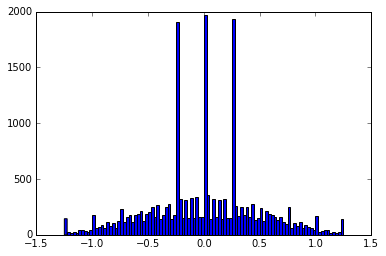

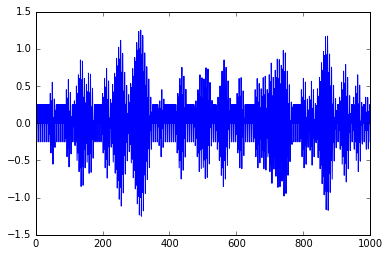

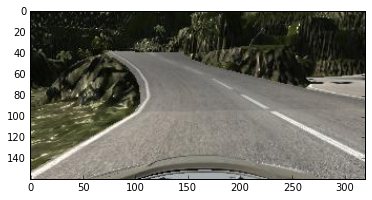

-0.0


In [4]:
#compiling data set without generator
lines = []
images = []
measurements = []

#logfiles = ['data/driving_log.csv']
#logfiles=['my_test_data_sb/driving_log.csv','my_test_data_sf/driving_log.csv']
logfiles=['my_test_data_track2/driving_log.csv']
for logfile in logfiles:
    with open(logfile) as csvfile:
        reader = csv.reader(csvfile)
        firstRead=True
        for line in reader:
            if firstRead:
                firstRead=False
            else:
                addRow(logfile.split('/')[0], line, images, measurements)
              
X_train = np.array(images)
y_train = np.array(measurements)

print("Number of images: ",len(X_train))

plt.hist(y_train,bins=100)
plt.show()

plt.plot(y_train[0:1000])
plt.show()

plt.imshow(X_train[1])
plt.show()
print(y_train[1])

Sigma =  0.4166666666666667
8638


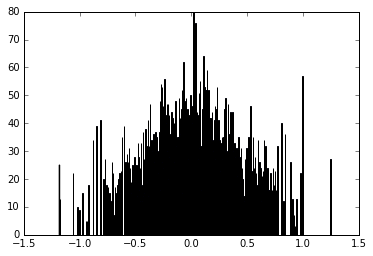

In [10]:
sigma = np.max(np.abs(y_train))/3
print("Sigma = ",sigma)

bufferFactor = 0.0001
normalImages=[]
normalSteering=[]

angles = np.random.normal(0,sigma,int(len(y_train)/3))

for angle in angles:
    choices = np.array(0)
    buffer = bufferFactor
    while(choices.size == 0 or choices.any() ==0):
        choices = np.where(np.logical_and(y_train>=(angle-buffer), y_train<=(angle+buffer)))[0]
        buffer+=bufferFactor
    
    pick = np.random.choice(choices)
    normalImages.append(X_train[pick])
    normalSteering.append(y_train[pick])
    
X_train_test = np.array(normalImages)
y_train_test = np.array(normalSteering)

print(len(y_train_test))
plt.hist(y_train_test,bins=500)
plt.show()


Number of images:  48216


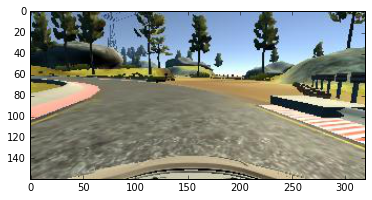

0.25


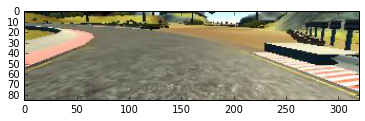

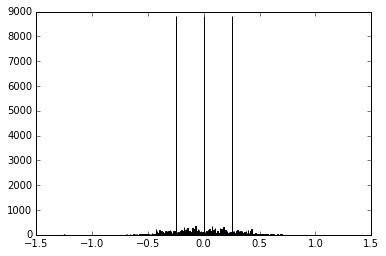

[ 0.25 -0.25 -0.  ]


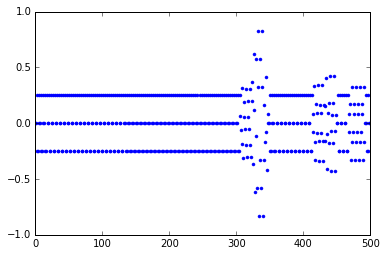

In [13]:
#View Data
print("Number of images: ",len(X_train))
image = X_train[102]
TestImage = image/255

plt.imshow(TestImage)
plt.show()
print(y_train[5000])


(y,x,z) = TestImage.shape

TestImage = TestImage[50:y-25,0:x]
#Check Preprocessing
plt.imshow(TestImage)
plt.show()

plt.hist(y_train,bins=500)
plt.show()

(values,counts)=np.unique(y_train, return_counts=True)
ind=counts.argsort()[-3:]

print(values[ind])

plt.plot(y_train[0:500],'.')
plt.show()

In [5]:
input = Input(shape=(160, 320, 3))

preProcess1 = Lambda(lambda x: x/255.0 - 0.5)(input)
#preProcess1 = Lambda(lambda x: x/127.5 -1.)(input)

crop1 = Cropping2D(cropping=((50,25),(0,0)), input_shape = (1,160,320))(preProcess1)

conv1 = Convolution2D(64, (7, 7), strides=2)(crop1)
conv1 = MaxPooling2D(pool_size=(3,3), strides=2)(conv1)

conv2 = Convolution2D(192, (3, 3), activation = 'relu', strides=1)(conv1)
conv2 = MaxPooling2D(pool_size=(3, 3), strides=2)(conv2)

#Incesption Layer
Inception1Conv1 = Convolution2D(64, (1, 1), padding='same', activation='relu')(conv2)
Inception1Conv2 = Convolution2D(128, (3, 3), padding='same', activation='relu')(conv2)
Inception1Conv3 = Convolution2D(32, (5, 5), padding='same', activation='relu')(conv2)
Inception1MP = MaxPooling2D(pool_size=(3,3), strides=1, padding='same')(conv2)

Inception1 = concatenate([Inception1Conv1, Inception1Conv2, Inception1Conv3, Inception1MP], axis=3)

drop1 = Dropout(0.4)(Inception1)
act1 = Activation('relu')(drop1)
Flat1=Flatten()(act1)

FCL2 = Dense(10, activation='elu')(Flat1)

output=Dense(1)(FCL2)

model = Model(inputs = input, outputs = output)
sgd = optimizers.SGD(lr=0.0000001, decay=1e-6)
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, validation_split = 0.2, shuffle=True, epochs = 10)

model.summary()

model.save('model.h5')
print("SAVED MODEL")



Train on 15960 samples, validate on 3990 samples
Epoch 1/10
15960/15960 [==============================] - 23s 1ms/step - loss: 0.1674 - val_loss: 0.1353
Epoch 2/10
15960/15960 [==============================] - 19s 1ms/step - loss: 0.1089 - val_loss: 0.1219
Epoch 3/10
15960/15960 [==============================] - 20s 1ms/step - loss: 0.0990 - val_loss: 0.1299
Epoch 4/10
15960/15960 [==============================] - 20s 1ms/step - loss: 0.0932 - val_loss: 0.1323
Epoch 5/10
15960/15960 [==============================] - 19s 1ms/step - loss: 0.0873 - val_loss: 0.1278
Epoch 6/10
15960/15960 [==============================] - 19s 1ms/step - loss: 0.0814 - val_loss: 0.1329
Epoch 7/10
15960/15960 [==============================] - 19s 1ms/step - loss: 0.0749 - val_loss: 0.1390
Epoch 8/10
15960/15960 [==============================] - 19s 1ms/step - loss: 0.0858 - val_loss: 0.1446
Epoch 9/10
15960/15960 [==============================] - 19s 1ms/step - loss: 0.0675 - val_loss: 0.1406
Epoch 

In [9]:
#Playing with architecture for challenging course
input = Input(shape=(160, 320, 3))

preProcess1 = Lambda(lambda x: x/255.0 - 0.5)(input)
#preProcess1 = Lambda(lambda x: x/127.5 -1.)(input)

crop1 = Cropping2D(cropping=((50,25),(0,0)), input_shape = (1,160,320))(preProcess1)

conv1 = Convolution2D(64, (7, 7), strides=2)(crop1)
conv1 = MaxPooling2D(pool_size=(3,3), strides=2)(conv1)

conv2 = Convolution2D(192, (3, 3), activation = 'relu', strides=1)(conv1)
conv2 = MaxPooling2D(pool_size=(3, 3), strides=2)(conv2)

#Incesption Layer
Inception1Conv1 = Convolution2D(64, (1, 1), padding='same', activation='relu')(conv2)
Inception1Conv2 = Convolution2D(128, (3, 3), padding='same', activation='relu')(conv2)
Inception1Conv3 = Convolution2D(32, (5, 5), padding='same', activation='relu')(conv2)
Inception1MP = MaxPooling2D(pool_size=(3,3), strides=1, padding='same')(conv2)

Inception1 = concatenate([Inception1Conv1, Inception1Conv2, Inception1Conv3, Inception1MP], axis=3)

drop1 = Dropout(0.4)(Inception1)
act1 = Activation('relu')(drop1)

#Incesption Layer
Inception2Conv1 = Convolution2D(64, (1, 1), padding='same', activation='relu')(act1)
Inception2Conv2 = Convolution2D(128, (3, 3), padding='same', activation='relu')(act1)
Inception2Conv3 = Convolution2D(32, (5, 5), padding='same', activation='relu')(act1)
Inception2MP = MaxPooling2D(pool_size=(3,3), strides=1, padding='same')(act1)

Inception2 = concatenate([Inception2Conv1, Inception2Conv2, Inception2Conv3, Inception2MP], axis=3)

drop2 = Dropout(0.4)(Inception2)
act2 = Activation('relu')(drop2)

Flat1=Flatten()(act2)

FCL2 = Dense(100, activation='relu')(Flat1)
FCL3 = Dense(10, activation='elu')(FCL2)
output=Dense(1)(FCL3)

model = Model(inputs = input, outputs = output)
sgd = optimizers.SGD(lr=0.00000001, decay=1e-6)
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, validation_split = 0.2, shuffle=True, epochs = 10)

model.summary()

model.save('model.h5')
print("SAVED MODEL")


Train on 3984 samples, validate on 996 samples
Epoch 1/10
3264/3984 [=======================>......] - ETA: 1s - loss: 10.9560

KeyboardInterrupt: 